In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [2]:
df = pd.read_csv('C:/Users/Krishi Vijayanand/Desktop/AB_NYC_2019.csv', sep = ',')
print(df.shape)

(48895, 16)


In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

<AxesSubplot:xlabel='price', ylabel='number_of_reviews'>

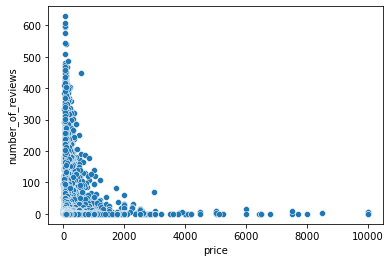

In [5]:
sns.scatterplot(x = df['price'], y = df['number_of_reviews'])

In [6]:
df.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [7]:
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

Skewness: 19.118939
Kurtosis: 585.672879


Text(0.5, 1.0, 'Price Distribution')

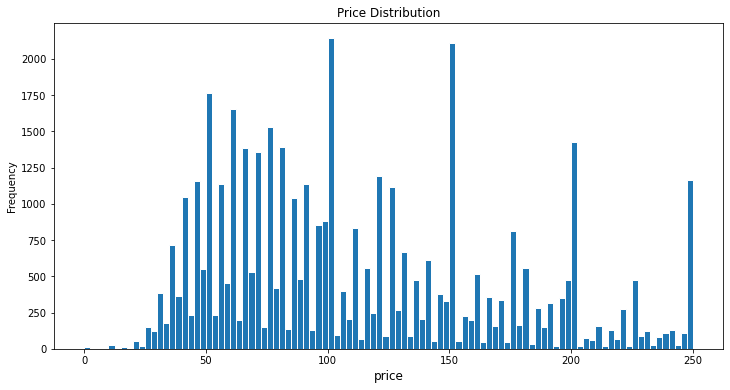

In [8]:
(df['price']).plot.hist(bins=100, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

Text(0.5, 1.0, 'Price Distribution')

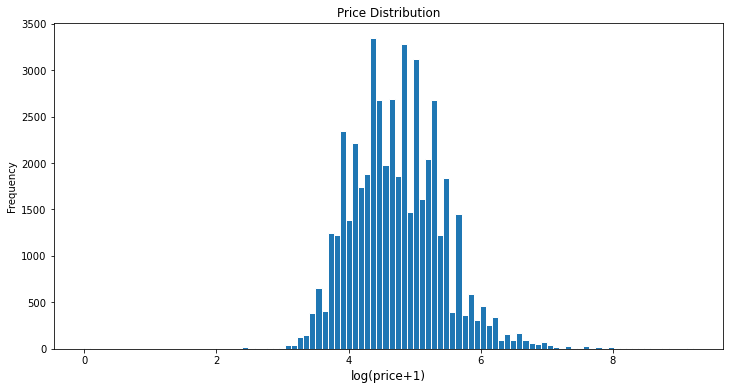

In [9]:
np.log(df['price']+1).plot.hist(bins=100, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [10]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Handling missing Data

In [11]:
df.name.fillna(value = "Not known", inplace = True)
df.host_name.fillna(value = "Not known", inplace = True)
df.last_review.fillna(value = "Not known", inplace = True)
df.reviews_per_month.fillna(0, inplace = True)

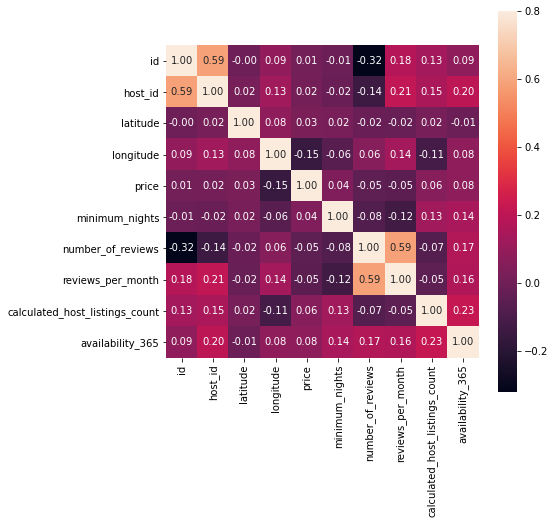

In [12]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

In [13]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

Room type Vs. Price

<AxesSubplot:xlabel='room_type', ylabel='price'>

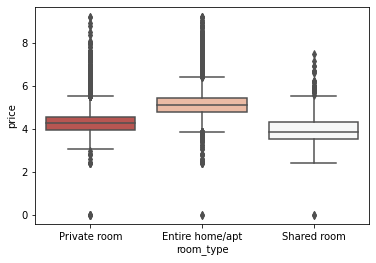

In [14]:
sns.boxplot(x = 'room_type', y = np.log(df['price']+1), data = df, palette = sns.color_palette('RdBu',5))

Analysing neighbourhood groups

In [15]:
df.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

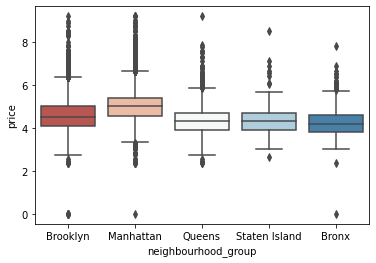

In [16]:
sns.boxplot(x = 'neighbourhood_group', y = np.log(df['price']+1), data = df, palette = sns.color_palette('RdBu',5))

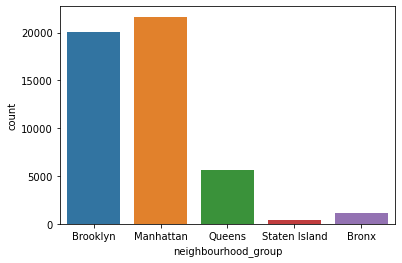

In [17]:
ax = sns.countplot(x="neighbourhood_group", data=df)

Dropping unnecessary data

In [18]:
df.drop(['name','id','host_name','last_review'], axis=1, inplace=True)

In [19]:
df.drop(['host_id'],axis=1,inplace=True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Text(0, 0.5, 'Price')

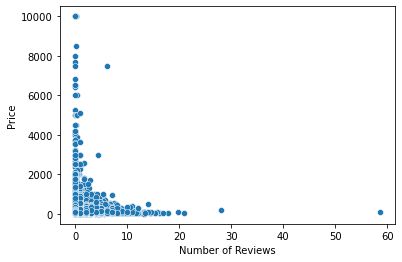

In [20]:
sns.scatterplot(x = df['reviews_per_month'], y = df['price'])
plt.xlabel('Number of Reviews')
plt.ylabel('Price')

Neighbouring group vs. availability

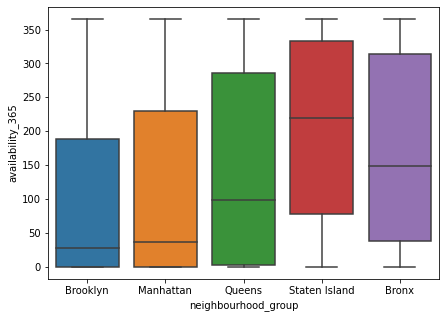

In [21]:
plt.figure(figsize=(7,5))
ax = sns.boxplot(data=df, x='neighbourhood_group',y='availability_365')

neighbouhood counts

C:\Users\Krishi Vijayanand\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


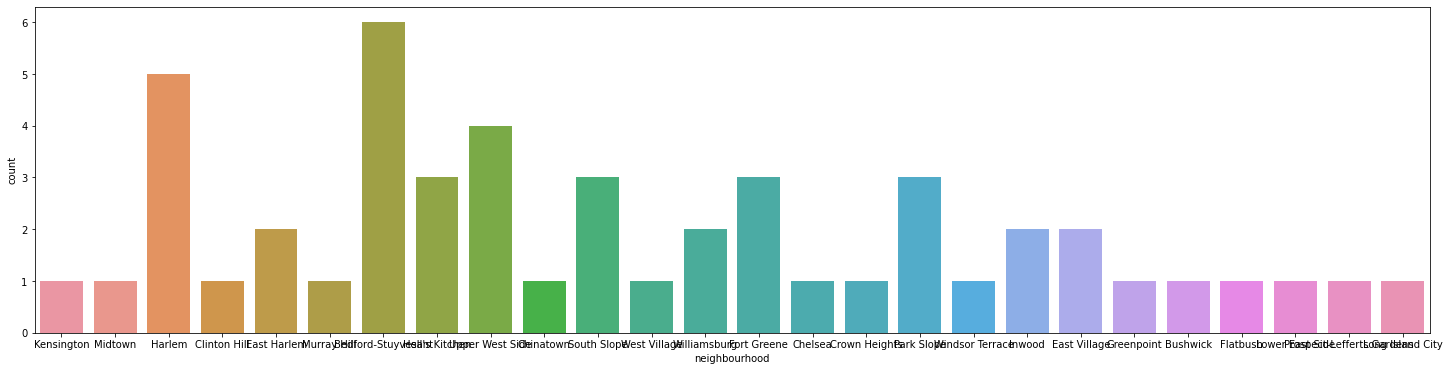

In [22]:
sns.countplot(df['neighbourhood'].iloc[:50])
fig = plt.gcf()
fig.set_size_inches(25,6)

Availability of rooms based on room types

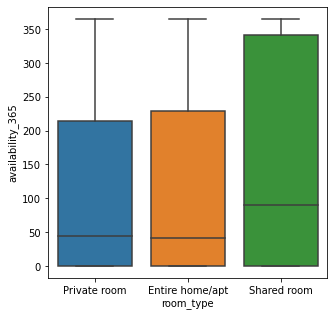

In [23]:
plt.figure(figsize=(5,5))
ax = sns.boxplot(data=df, x='room_type',y='availability_365')

Converting categorical data to integer for lightGBM

In [24]:
df['room_type'] = df['room_type'].factorize()[0]
df['neighbourhood_group'] = df['neighbourhood_group'].factorize()[0] 
df['neighbourhood'] = df['neighbourhood'].factorize()[0] 

In [25]:
df.head() 

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0,0,40.64749,-73.97237,0,149,1,9,0.21,6,365
1,1,1,40.75362,-73.98377,1,225,1,45,0.38,2,355
2,1,2,40.80902,-73.94190,0,150,3,0,0.00,1,365
3,0,3,40.68514,-73.95976,1,89,1,270,4.64,1,194
4,1,4,40.79851,-73.94399,1,80,10,9,0.10,1,0


plotting airbnb

C:\Users\Krishi Vijayanand\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


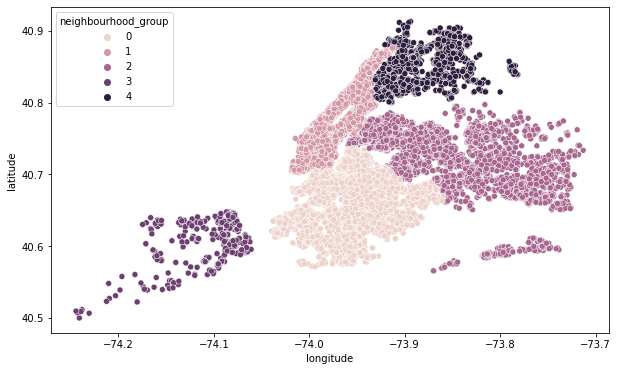

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude, df.latitude, hue=df.neighbourhood_group)
plt.ioff()

C:\Users\Krishi Vijayanand\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


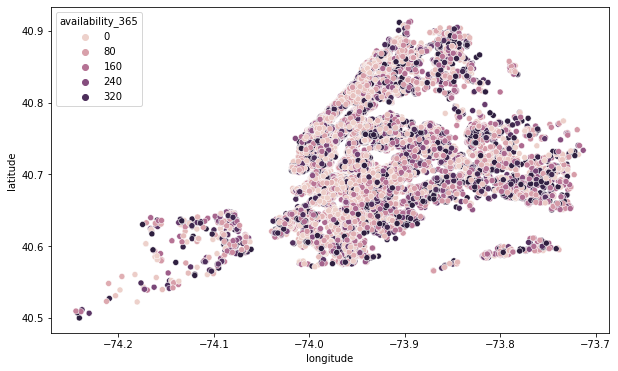

In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude, df.latitude, hue = df.availability_365)
plt.ioff()

In [28]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0,0,40.64749,-73.97237,0,149,1,9,0.21,6,365
1,1,1,40.75362,-73.98377,1,225,1,45,0.38,2,355
2,1,2,40.80902,-73.94190,0,150,3,0,0.00,1,365
3,0,3,40.68514,-73.95976,1,89,1,270,4.64,1,194
4,1,4,40.79851,-73.94399,1,80,10,9,0.10,1,0


C:\Users\Krishi Vijayanand\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


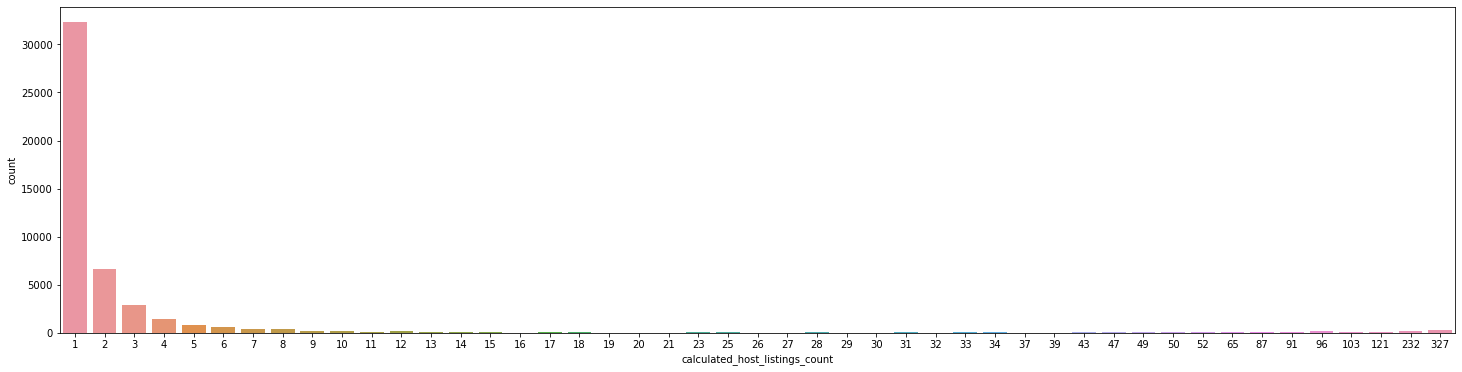

In [29]:
sns.countplot(df['calculated_host_listings_count'])
fig = plt.gcf()
fig.set_size_inches(25,6)

C:\Users\Krishi Vijayanand\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


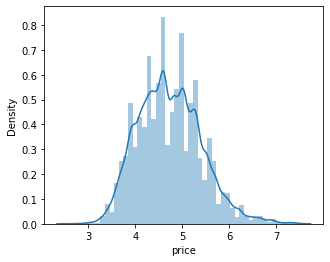

In [30]:
df = df[np.log1p(df['price']) < 7.5]
df = df[np.log1p(df['price']) > 2.5]

# Plotting the new log(Price) curve after removing the outliers
plt.figure(figsize=(5,4))
sns.distplot(np.log1p(df['price']))
plt.show()

In [31]:
df.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [32]:
x = df.iloc[:,[1,3,4,6,9]]

y = df['price']
y2 = np.log1p(df['price'])

In [33]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [34]:
x_train,x_test,y_train,y_test=train_test_split(x,y2,test_size=.1,random_state=7)
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(x_train,y_train)
y_pred=reg.predict(x_test)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.5578908673442


In [35]:
x_train1,x_test1,y_train1,y_test1 = train_test_split(x,y2,test_size=.1,random_state=7)
gbm = lgb.LGBMRegressor(objective='regression', num_leaves=10, learning_rate=0.05, 
                        max_depth = 3, metric = 'RMSE', verbosity  = 1)
gbm.fit(x_train1, y_train1)
y_pred1 = gbm.predict(x_test1)
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test1, y_pred1) ** 0.5)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 43872, number of used features: 5
[LightGBM] [Info] Start training from score 4.729924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain